# **Imported libraries**

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, classification_report
from imblearn.combine import SMOTEENN
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
import os
import math
import warnings
warnings.filterwarnings('ignore')

In [7]:
import imblearn
# tuning model, get different metric scores, and split data
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    make_scorer,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    ConfusionMatrixDisplay,
)
from sklearn.model_selection import StratifiedKFold, cross_val_score

# imputing missing values
from sklearn.impute import SimpleImputer
from sklearn import metrics

from sklearn.model_selection import cross_val_score

# oversample and undersample data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

# define maximum number of columns to be displayed in a dataframe
pd.set_option("display.max_columns", None)

# supress scientific notations for a dataframe
pd.set_option("display.float_format", lambda x: "%.3f" % x)

# help with model building
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    BaggingClassifier,
)
from xgboost import XGBClassifier

# **Loading Data**

In [11]:
X_train = pd.read_csv('train_data_scaled.csv')
X_val = pd.read_csv('val_data_scaled.csv')
test_data_scaled = pd.read_csv('test_data_scaled.csv')
y_train = pd.read_csv('y_train.csv')
y_val = pd.read_csv('y_val.csv')

In [12]:
X_train.shape

(401818, 20)

In [15]:
y_val = y_val.set_index('Claim Identifier')['Claim Injury Type']
y_train = y_train.set_index('Claim Identifier')['Claim Injury Type']
X_val = X_val.set_index('Claim Identifier')
X_train = X_train.set_index('Claim Identifier')
test_data_scaled = test_data_scaled.set_index('Claim Identifier')

In [50]:
#sample the data for efficiency
X_sample, _, y_sample, _ = train_test_split(X_val, y_val, test_size=0.9, random_state=15)

### **SMOTE - Synthetic Minority Oversampling Technique**

In [89]:
print("Class distribution:", Counter(y_train))

Class distribution: Counter({1: 203754, 3: 103955, 2: 48234, 4: 33796, 0: 8734, 5: 2948, 7: 329, 6: 68})


**The target distribution is definitely imbalanced.**

In [95]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print("Class distribution after SMOTE:", Counter(y_train_resampled))

Class distribution after SMOTE: Counter({1: 203754, 3: 203754, 2: 203754, 4: 203754, 0: 203754, 5: 203754, 7: 203754, 6: 203754})


In [98]:
sampling_strategy = {
    0: 20000,  # Keep original count
    1: 203754, # Keep original count
    2: 48234,  # Keep original count
    3: 103955, # Keep original count
    4: 33796, # Keep original count or slightly oversample
    5: 10000,   # Oversample to around 5,000 instances
    6: 2500,   # Oversample to around 5,000 instances
    7: 5000    # Oversample to around 2,500 instances
}

In [101]:
sm = SMOTE(sampling_strategy=sampling_strategy, k_neighbors=5, random_state=42)
X_train_resampled, y_train_resampled= sm.fit_resample(X_train, y_train)

### **Undersampling**

In [112]:
undersampler = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)
print("Class distribution after undersampling:", Counter(y_train_resampled))

Class distribution after undersampling: Counter({0: 68, 1: 68, 2: 68, 3: 68, 4: 68, 5: 68, 6: 68, 7: 68})


### **Oversampling and Undersampling**

In [115]:
smote_enn = SMOTEENN(random_state=42)
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train, y_train)
print("Class distribution after SMOTEENN:", Counter(y_train_resampled))

Class distribution after SMOTEENN: Counter({6: 203754, 7: 203754, 5: 203460, 0: 200632, 4: 196824, 2: 164081, 3: 132933, 1: 106592})


### **Class Weighting**

In [117]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
print("Class weights:", class_weight_dict)

Class weights: {0: 5.750772841767804, 1: 0.24650927098363712, 2: 1.0413245843181158, 3: 0.483163388004425, 4: 1.486189193987454, 5: 17.037737449118048, 6: 738.6360294117648, 7: 152.6664133738602}


### **Models Evaluation**

In [12]:
target_mapping = {
    0: '1. CANCELLED',
    1: '2. NON-COMP',
    2: '3. MED ONLY',
    3: '4. TEMPORARY',
    4: '5. PPD SCH LOSS',
    5: '6. PPD NSL',
    6: '7. PTD',
    7: '8. DEATH'
}
# Initialize models
models = {
    #"Logistic Regression": LogisticRegression(max_iter=200),
    #"Random Forest": RandomForestClassifier(random_state=42),
    #"Decision Tree": DecisionTreeClassifier(random_state=42),
    #"Bagging": BaggingClassifier(random_state=42),
    #"KNeighborsClassifier": KNeighborsClassifier(),
    #"GBM": GradientBoostingClassifier(random_state=42),
    "XGB": XGBClassifier(random_state=42),
    #"Neural Network": MLPClassifier(random_state=42)
}
results = {}
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred_encoded = model.predict(X_val)
    results[name] = {
        'model': model,
        'f1_macro': f1_score(y_val, y_pred_encoded, average='macro'),
        'accuracy': accuracy_score(y_val, y_pred_encoded)
    }
    
print("\nModel Evaluation Results:")
for model_name, metrics in results.items():
    print(f"{model_name}: F1 macro = {metrics['f1_macro']:.4f}, Accuracy = {metrics['accuracy']:.4f}")

Training XGB...

Model Evaluation Results:
XGB: F1 macro = 0.4222, Accuracy = 0.7879


In [13]:
predictions = {}
for name, model in models.items():
        print(f"Predicting with {name}...")
        predictions[name] = model.predict(test_data_scaled)  # Predict on df_test
    
for name, preds in predictions.items():
     # Reverse encode the predictions using target_mapping
    preds_decoded = [target_mapping[pred] for pred in preds]  # Decode predictions
    predictions_df = pd.DataFrame({
        'Claim Identifier': test_data_scaled.index,
        'Claim Injury Type': preds_decoded
    })
    # Save to CSV
    predictions_df.to_csv(f'{name}_predictions.csv', index=False)
    print(f"Predictions for {name} saved to '{name}_predictions.csv'")

Predicting with XGB...
Predictions for XGB saved to 'XGB_predictions.csv'


## **XGBoost - Finding best parameters**

In [42]:
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 2, random_state = 1)

In [44]:
def return_f1score(model, X, y):
    # Use cross-validation with F1 score as the evaluation metric
    return cross_val_score(model, X, y, scoring=make_scorer(f1_score, average='macro'), cv=cv)

In [46]:
def return_results(models):
    results, names = [],[]
    for name, model in models.items():
        scores = return_f1score(model, X_sample, y_sample)
        results.append(scores)
        names.append(name)
        print('>%s %.3f (%.3f)' % (name, scores.mean(), scores.std()))
    
    plt.figure(figsize=(15,7))
    plt.boxplot(results, labels = names, showmeans = True)
    plt.xticks(fontsize=14)
    plt.show()

In [52]:
print(X_sample.isna().sum())
print(y_sample.isna().sum())

Days_Accident_to_First_Hearing    0
IME-4 Count                       0
Average Weekly Wage               0
Attorney/Representative           0
WCIO Cause of Injury Code         0
WCIO Part Of Body Code            0
Region_Risk_Score                 0
C2_After_C3_Flag                  0
C3_After_Assembly_Flag            0
C-3 Date Converted                0
Days_Accident_to_C3               0
Carrier Name                      0
Birth Year                        0
Days_Accident_to_Assembly         0
District Name                     0
Medical Fee Region                0
Accident_Month                    0
Age_Outlier_Flag                  0
County_Claims_Normalized          0
dtype: int64
0


In [54]:
# Create an instance of XGBClassifier
xgb_model = XGBClassifier(random_state=15)

# Fit the model
xgb_model.fit(X_train, y_train)

# Evaluate the model
print(xgb_model.score(X_val, y_val))

0.7878786119111771


>XGB_gbtree nan (nan)
>XGB_gblinear nan (nan)
>XGB_dart nan (nan)


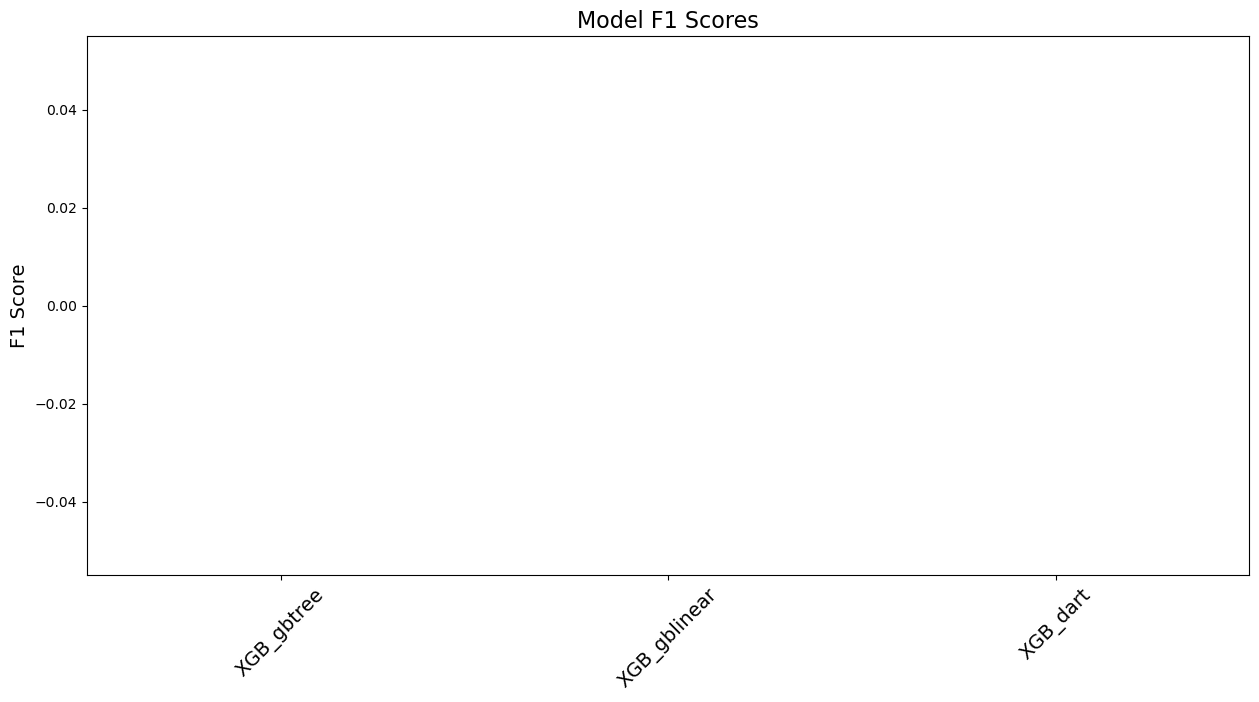

In [55]:
# Function to calculate F1 scores
def return_f1score(model, X, y):
    return cross_val_score(model, X, y, scoring=make_scorer(f1_score, average='macro'), cv=5)

# Function to return results and plot
def return_results(models):
    results, names = [], []
    for name, model in models.items():
        scores = return_f1score(model, X_sample, y_sample)  # Use the dataset
        results.append(scores)
        names.append(name)
        print('>%s %.3f (%.3f)' % (name, scores.mean(), scores.std()))
    
    plt.figure(figsize=(15, 7))
    plt.boxplot(results, labels=names, showmeans=True)
    plt.xticks(fontsize=14, rotation=45)
    plt.ylabel("F1 Score", fontsize=14)
    plt.title("Model F1 Scores", fontsize=16)
    plt.show()

# Function to generate models
def get_models(values):
    models = dict()
    for value in values:
        models[f"XGB_{value}"] = XGBClassifier(boster=value, random_state=15)
    return models

# Generate models with varying n_estimators
models = get_models(['gbtree','gblinear','dart'])

# Ensure your dataset is correctly prepared
# X_sample and y_sample must be defined and preprocessed before calling `return_results`
return_results(models)

Training XGB_2...
>XGB_2: Mean F1 = 0.320, Std F1 = 0.006
Training XGB_5...
>XGB_5: Mean F1 = 0.337, Std F1 = 0.006
Training XGB_10...
>XGB_10: Mean F1 = 0.359, Std F1 = 0.006
Training XGB_20...
>XGB_20: Mean F1 = 0.385, Std F1 = 0.007
Training XGB_30...
>XGB_30: Mean F1 = 0.398, Std F1 = 0.006
Training XGB_50...
>XGB_50: Mean F1 = 0.409, Std F1 = 0.007
Training XGB_100...
>XGB_100: Mean F1 = 0.414, Std F1 = 0.006
Training XGB_150...
>XGB_150: Mean F1 = 0.419, Std F1 = 0.006
Training XGB_200...
>XGB_200: Mean F1 = 0.417, Std F1 = 0.005


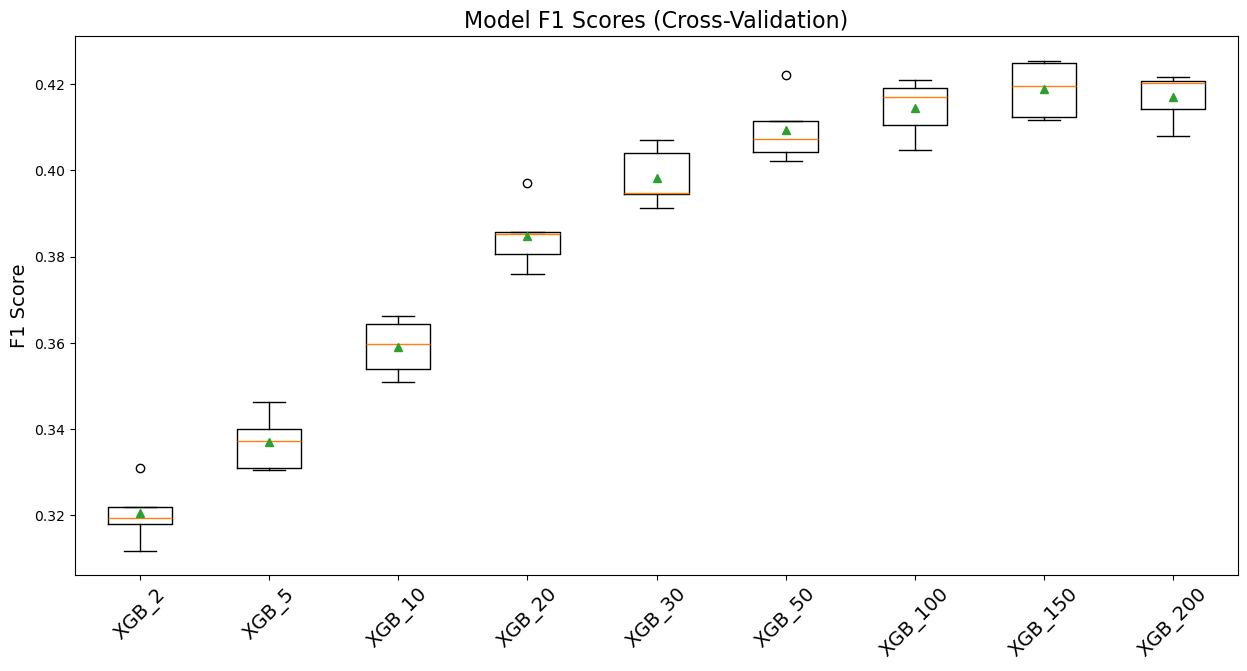

In [56]:
# Define return_f1score function
def return_f1score(model, X, y):
    """Returns F1 scores for cross-validation."""
    return cross_val_score(
        model, 
        X, 
        y, 
        scoring='f1_macro',  # Macro F1 for multi-class problems
        cv=5  # 5-fold cross-validation
    )

# Define return_results function
def return_results(models):
    """Trains models and plots F1 scores."""
    results, names = [], []
    
    for name, model in models.items():
        print(f"Training {name}...")
        try:
            # Calculate F1 scores using cross-validation
            scores = return_f1score(model, X_sample, y_sample)
            results.append(scores)
            names.append(name)
            print(f">{name}: Mean F1 = {scores.mean():.3f}, Std F1 = {scores.std():.3f}")
        except Exception as e:
            print(f"Error with model {name}: {e}")
    
    # Plot the results
    plt.figure(figsize=(15, 7))
    if results:
        plt.boxplot(results, labels=names, showmeans=True)
        plt.xticks(fontsize=14, rotation=45)
        plt.ylabel('F1 Score', fontsize=14)
        plt.title('Model F1 Scores (Cross-Validation)', fontsize=16)
        plt.show()
    else:
        print("No results to display in the plot.")

# Define get_models function
def get_models(values):
    """Generates a dictionary of XGBClassifier models with varying n_estimators."""
    models = {}
    for value in values:
        models[f"XGB_{value}"] = XGBClassifier(n_estimators=value, random_state=42)
    return models

# Create the dataset (ensure X_sample and y_sample are defined)
# Replace these with your actual dataset
X_sample = X_train  # Replace with your sampled X_train
y_sample = y_train  # Replace with your sampled y_train

# Generate models with varying n_estimators
models = get_models([2, 5, 10, 20, 30, 50, 100, 150, 200])

# Evaluate and plot results
return_results(models)

### **150 estimators**

Training XGB_gbtree...
>XGB_gbtree: Mean F1 = 0.414, Std F1 = 0.006
Training XGB_gblinear...
>XGB_gblinear: Mean F1 = 0.291, Std F1 = 0.006
Training XGB_dart...
>XGB_dart: Mean F1 = 0.414, Std F1 = 0.006


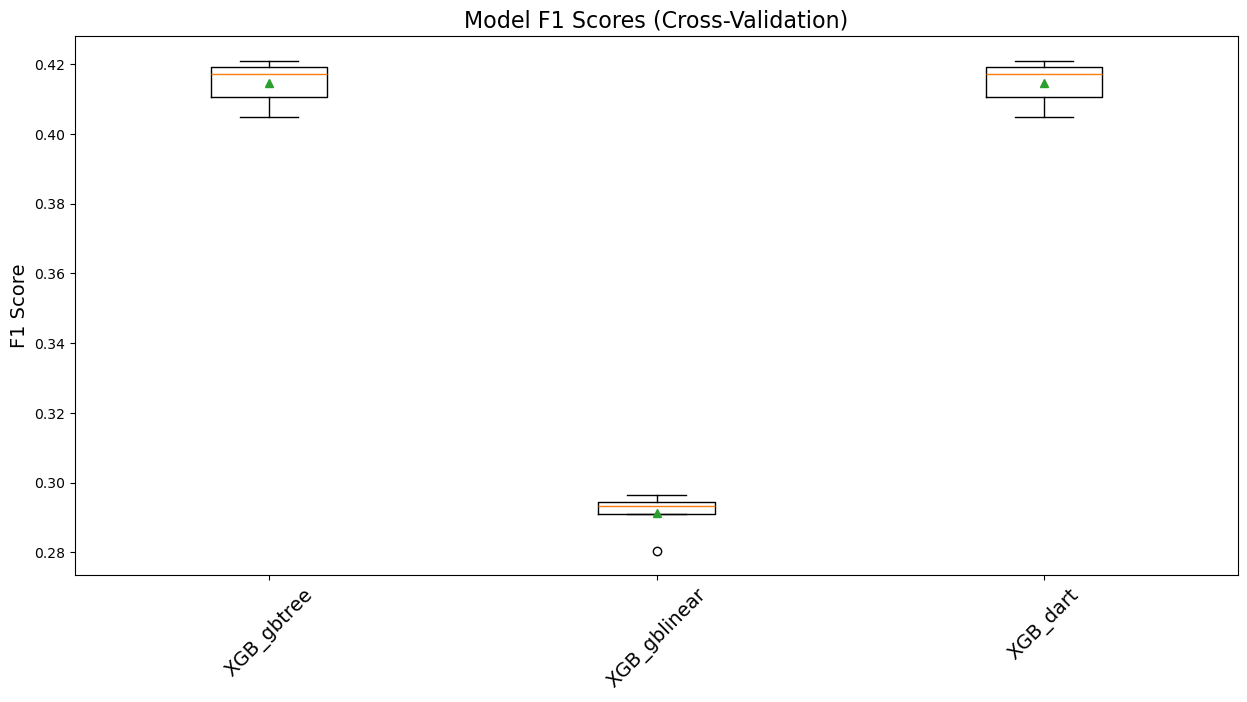

In [59]:
# Define return_f1score function
def return_f1score(model, X, y):
    """Returns F1 scores for cross-validation."""
    return cross_val_score(
        model, 
        X, 
        y, 
        scoring='f1_macro',  # Macro F1 for multi-class problems
        cv=5  # 5-fold cross-validation
    )

# Define return_results function
def return_results(models):
    """Trains models and plots F1 scores."""
    results, names = [], []
    
    for name, model in models.items():
        print(f"Training {name}...")
        try:
            # Calculate F1 scores using cross-validation
            scores = return_f1score(model, X_sample, y_sample)
            results.append(scores)
            names.append(name)
            print(f">{name}: Mean F1 = {scores.mean():.3f}, Std F1 = {scores.std():.3f}")
        except Exception as e:
            print(f"Error with model {name}: {e}")
    
    # Plot the results
    plt.figure(figsize=(15, 7))
    if results:
        plt.boxplot(results, labels=names, showmeans=True)
        plt.xticks(fontsize=14, rotation=45)
        plt.ylabel('F1 Score', fontsize=14)
        plt.title('Model F1 Scores (Cross-Validation)', fontsize=16)
        plt.show()
    else:
        print("No results to display in the plot.")

# Define get_models function
def get_models(values):
    """Generates a dictionary of XGBClassifier models with varying n_estimators."""
    models = {}
    for value in values:
        models[f"XGB_{value}"] = XGBClassifier(booster=value, random_state=42)
    return models

# Create the dataset (ensure X_sample and y_sample are defined)
# Replace these with your actual dataset
X_sample = X_train  # Replace with your sampled X_train
y_sample = y_train  # Replace with your sampled y_train

# Generate models with varying n_estimators
models = get_models(['gbtree','gblinear','dart'])

# Evaluate and plot results
return_results(models)

### **MAX BIN**

Training XGB_150...
>XGB_150: Mean F1 = 0.415, Std F1 = 0.004
Training XGB_200...
>XGB_200: Mean F1 = 0.414, Std F1 = 0.006
Training XGB_256...
>XGB_256: Mean F1 = 0.414, Std F1 = 0.006
Training XGB_300...
>XGB_300: Mean F1 = 0.415, Std F1 = 0.005


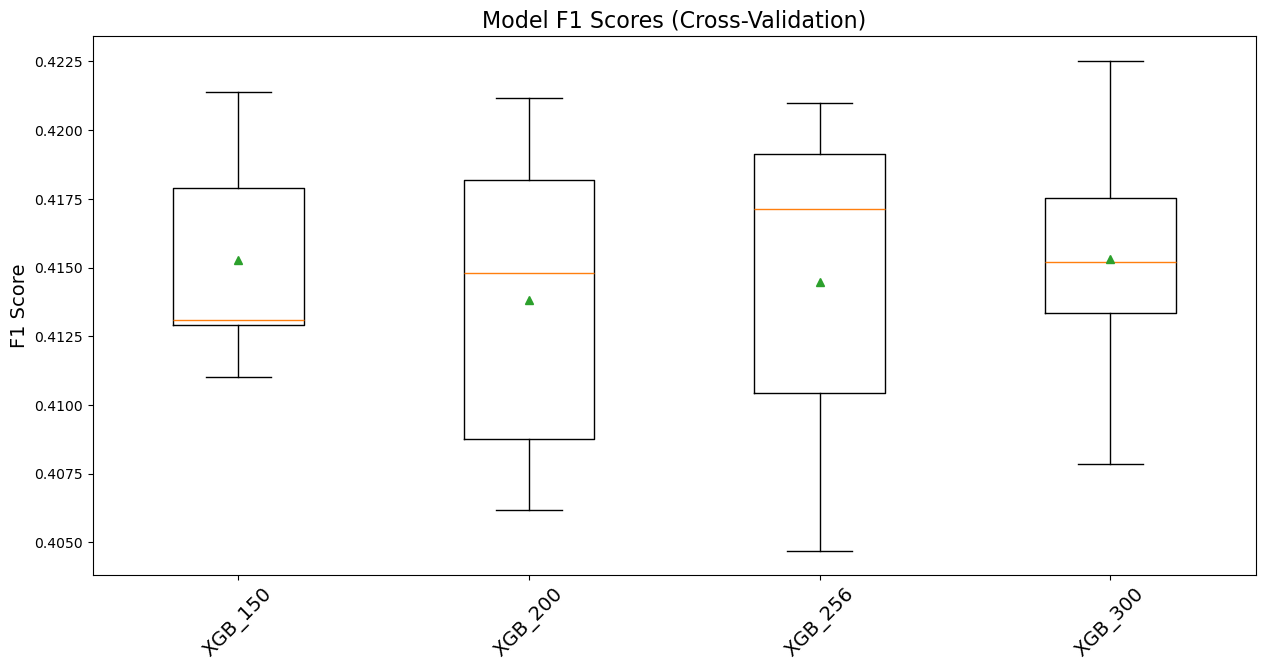

In [72]:
# Define return_f1score function
def return_f1score(model, X, y):
    """Returns F1 scores for cross-validation."""
    return cross_val_score(
        model, 
        X, 
        y, 
        scoring='f1_macro',  # Macro F1 for multi-class problems
        cv=5  # 5-fold cross-validation
    )

# Define return_results function
def return_results(models):
    """Trains models and plots F1 scores."""
    results, names = [], []
    
    for name, model in models.items():
        print(f"Training {name}...")
        try:
            # Calculate F1 scores using cross-validation
            scores = return_f1score(model, X_sample, y_sample)
            results.append(scores)
            names.append(name)
            print(f">{name}: Mean F1 = {scores.mean():.3f}, Std F1 = {scores.std():.3f}")
        except Exception as e:
            print(f"Error with model {name}: {e}")
    
    # Plot the results
    plt.figure(figsize=(15, 7))
    if results:
        plt.boxplot(results, labels=names, showmeans=True)
        plt.xticks(fontsize=14, rotation=45)
        plt.ylabel('F1 Score', fontsize=14)
        plt.title('Model F1 Scores (Cross-Validation)', fontsize=16)
        plt.show()
    else:
        print("No results to display in the plot.")

# Define get_models function
def get_models(values):
    """Generates a dictionary of XGBClassifier models with varying n_estimators."""
    models = {}
    for value in values:
        models[f"XGB_{value}"] = XGBClassifier(max_bin=value, random_state=42)
    return models

# Create the dataset (ensure X_sample and y_sample are defined)
# Replace these with your actual dataset
X_sample = X_train  # Replace with your sampled X_train
y_sample = y_train  # Replace with your sampled y_train

# Generate models with varying n_estimators
models = get_models([150,200,256,300,])

# Evaluate and plot results
return_results(models)

### **LEARNINGRATE** 

Training XGB_0.05...
>XGB_0.05: Mean F1 = 0.373, Std F1 = 0.006
Training XGB_0.1...
>XGB_0.1: Mean F1 = 0.400, Std F1 = 0.006
Training XGB_0.2...
>XGB_0.2: Mean F1 = 0.415, Std F1 = 0.006
Training XGB_0.3...
>XGB_0.3: Mean F1 = 0.414, Std F1 = 0.006
Training XGB_0.5...
>XGB_0.5: Mean F1 = 0.415, Std F1 = 0.006


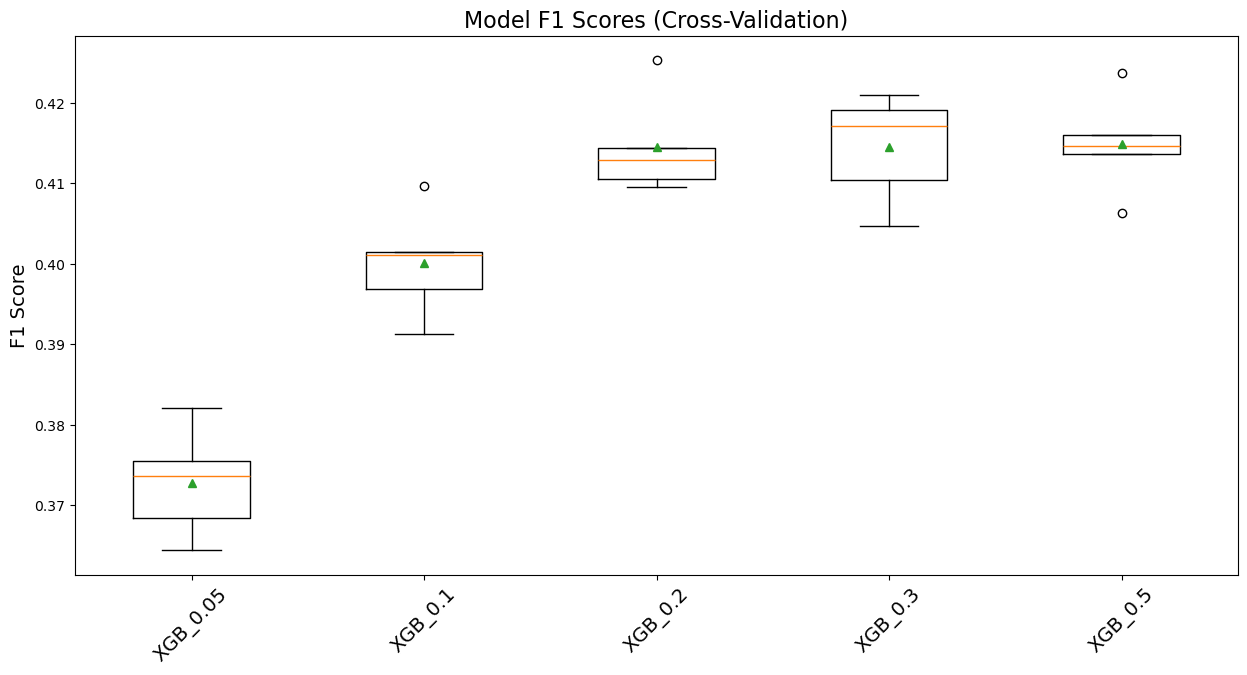

In [73]:
# Define return_f1score function
def return_f1score(model, X, y):
    """Returns F1 scores for cross-validation."""
    return cross_val_score(
        model, 
        X, 
        y, 
        scoring='f1_macro',  # Macro F1 for multi-class problems
        cv=5  # 5-fold cross-validation
    )

# Define return_results function
def return_results(models):
    """Trains models and plots F1 scores."""
    results, names = [], []
    
    for name, model in models.items():
        print(f"Training {name}...")
        try:
            # Calculate F1 scores using cross-validation
            scores = return_f1score(model, X_sample, y_sample)
            results.append(scores)
            names.append(name)
            print(f">{name}: Mean F1 = {scores.mean():.3f}, Std F1 = {scores.std():.3f}")
        except Exception as e:
            print(f"Error with model {name}: {e}")
    
    # Plot the results
    plt.figure(figsize=(15, 7))
    if results:
        plt.boxplot(results, labels=names, showmeans=True)
        plt.xticks(fontsize=14, rotation=45)
        plt.ylabel('F1 Score', fontsize=14)
        plt.title('Model F1 Scores (Cross-Validation)', fontsize=16)
        plt.show()
    else:
        print("No results to display in the plot.")

# Define get_models function
def get_models(values):
    """Generates a dictionary of XGBClassifier models with varying n_estimators."""
    models = {}
    for value in values:
        models[f"XGB_{value}"] = XGBClassifier(learning_rate=value, random_state=42)
    return models

# Create the dataset (ensure X_sample and y_sample are defined)
# Replace these with your actual dataset
X_sample = X_train  # Replace with your sampled X_train
y_sample = y_train  # Replace with your sampled y_train

# Generate models with varying n_estimators
models = get_models([0.05, 0.1, 0.2, 0.3, 0.5])

# Evaluate and plot results
return_results(models)

### **Models with tuning using GridSearchCV and RandomizedSearchCV**

## 